In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from tools import reduce_mem_usage, chk_dist
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.font_manager as fm

In [2]:
# 글꼴 한국어도 가능하도록 설정
path = 'c:\\windows\\fonts\\NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

# DIR 설정
data_dir = 'C:\\Users\\CSH\\Desktop\\lpoint\\data\\'

In [3]:
product = pd.read_csv(data_dir + 'product.csv')
product.info()

C:\Users\CSH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024906 entries, 0 to 5024905
Data columns (total 8 columns):
CLNT_ID      int64
SESS_ID      int64
HITS_SEQ     int64
PD_C         int64
PD_ADD_NM    object
PD_BRA_NM    object
PD_BUY_AM    object
PD_BUY_CT    object
dtypes: int64(4), object(4)
memory usage: 306.7+ MB


In [4]:
product['PD_BUY_CT'] = product['PD_BUY_CT'].apply(lambda x: str(x))
product['PD_BUY_CT'] = product['PD_BUY_CT'].apply(lambda x: int(x.replace(',','')))

Session ID 별로 구매 건수에 대한 정보를 파악하기 위해 위 데이터를 CLNT ID, Session ID 를 기준으로 묶겠다.

In [5]:
buy_cnt_sess = product[['CLNT_ID', 'SESS_ID', 'PD_BUY_CT']].groupby(
    ['CLNT_ID', 'SESS_ID'], as_index=False).sum()

In [6]:
chk_dist(buy_cnt_sess['PD_BUY_CT'], "구매 건수")

평균 구매 건수는 2.182 건, 상위 99%의 구매 건수는 11 건이며 최고 구매 건수는 2420 건이다.


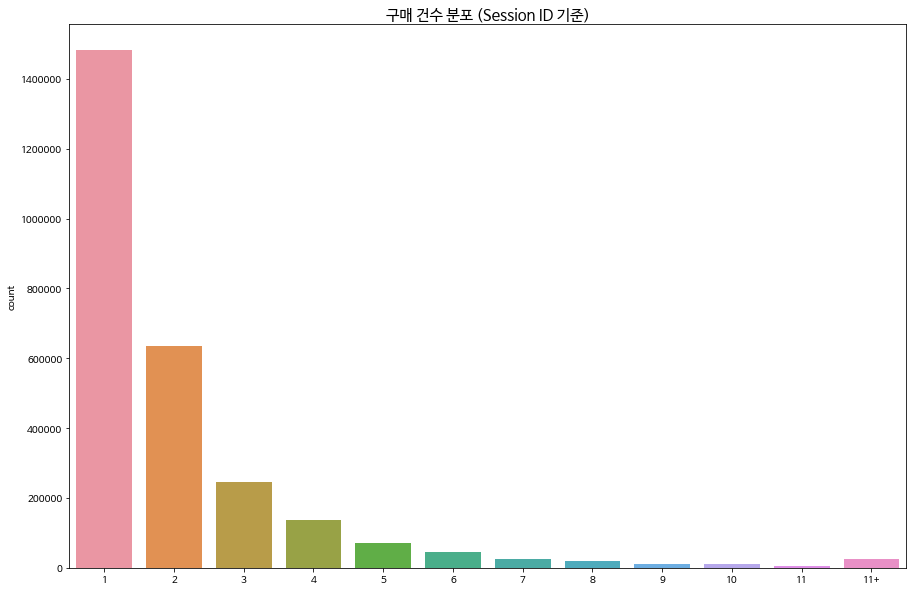

In [7]:
data = buy_cnt_sess.copy()
data.loc[data['PD_BUY_CT'] > data['PD_BUY_CT'].quantile(0.99)] = '11+'
plt.figure(figsize=(15,10))
sns.countplot(sorted(data['PD_BUY_CT'].astype(str), key = lambda x: x if len(x) == 1 else '9' + x))
plt.title('구매 건수 분포 (Session ID 기준)', fontsize = 15)
plt.show()

구매 건수가 변수들과 어떤 상관 관계를 보이는지 한번 살펴보겠다. 먼저 총 페이지 조회 건수가 구매 건수와 어떤 관계를 보이는지 살펴보겠다.

# 총 페이지 조회 건수

In [8]:
session = pd.read_csv(data_dir + 'session.csv')
session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712907 entries, 0 to 2712906
Data columns (total 9 columns):
CLNT_ID            int64
SESS_ID            int64
SESS_SEQ           int64
SESS_DT            int64
TOT_PAG_VIEW_CT    float64
TOT_SESS_HR_V      object
DVC_CTG_NM         object
ZON_NM             object
CITY_NM            object
dtypes: float64(1), int64(4), object(4)
memory usage: 186.3+ MB


C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


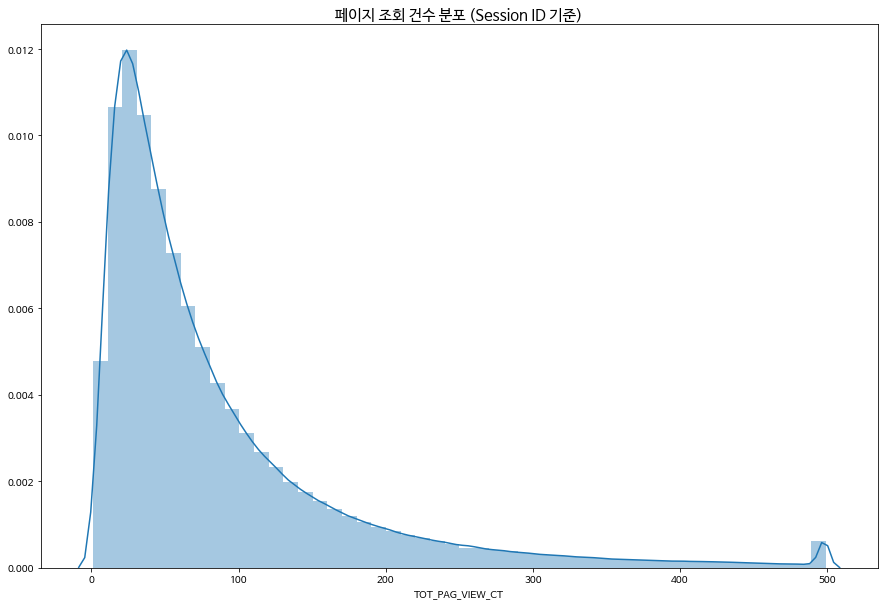

In [9]:
data = session['TOT_PAG_VIEW_CT'][~session['TOT_PAG_VIEW_CT'].isnull()]
plt.figure(figsize = (15,10))
plt.title("페이지 조회 건수 분포 (Session ID 기준)", fontsize=15)
sns.distplot(data)
plt.show()

In [10]:
chk_dist(session['TOT_PAG_VIEW_CT'], "페이지 조회 건수")

평균 페이지 조회 건수는 85.168 건, 상위 99%의 페이지 조회 건수는 448 건이며 최고 페이지 조회 건수는 499 건이다.


In [11]:
buy_cnt_sess_merged = buy_cnt_sess.merge(session, on = ['CLNT_ID', 'SESS_ID'], how = 'left')
buy_cnt_sess_merged.isnull().sum(axis=0)

CLNT_ID                0
SESS_ID                0
PD_BUY_CT              0
SESS_SEQ               0
SESS_DT                0
TOT_PAG_VIEW_CT      274
TOT_SESS_HR_V      14202
DVC_CTG_NM             0
ZON_NM                 0
CITY_NM                0
dtype: int64

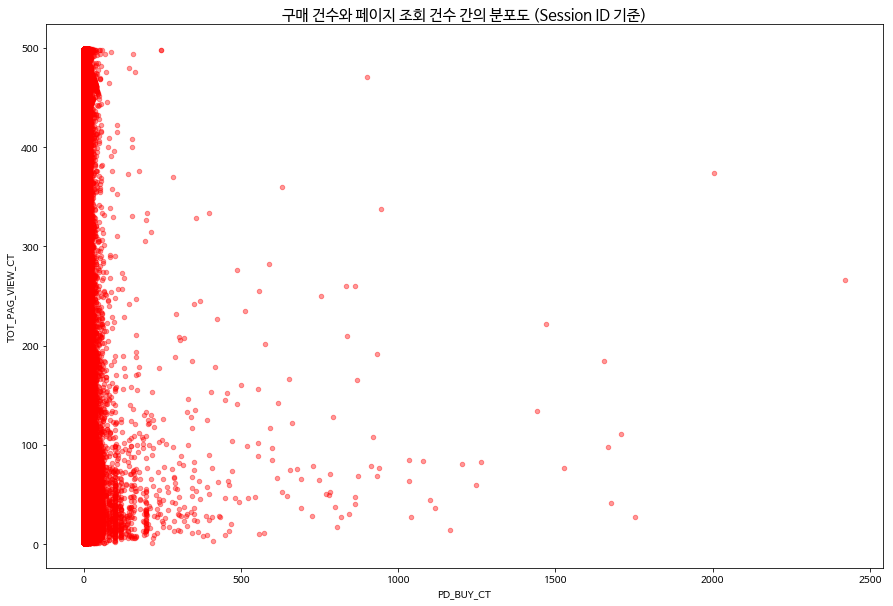

구매 건수와 페이지 조회 건수 간의 상관관계: 0.051


In [12]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_PAG_VIEW_CT'].isnull()]
data.plot(kind='scatter', x="PD_BUY_CT", y="TOT_PAG_VIEW_CT", alpha=0.4, color='red',
         figsize=(15,10))
plt.title('구매 건수와 페이지 조회 건수 간의 분포도 (Session ID 기준)', fontsize=15)
plt.show()
print("구매 건수와 페이지 조회 건수 간의 상관관계: %.3f" %np.corrcoef(data['TOT_PAG_VIEW_CT'], data['PD_BUY_CT'])[1,0])

특별한 관계가 보이지 않는다.
이번에는 총 세션 시간값과 구매 건수 간에 상관 관계를 확인해보겠다.

# 총 세션 시간 값

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


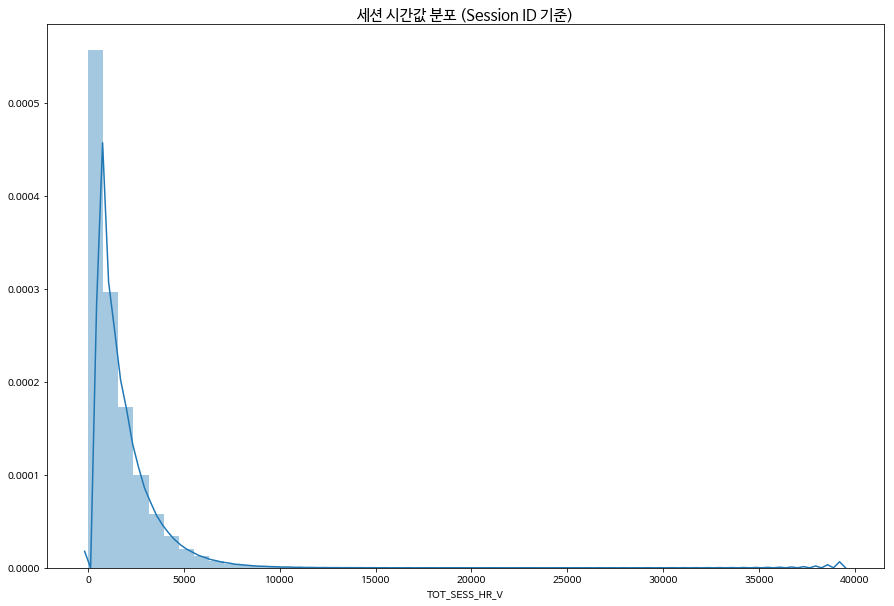

In [13]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<50]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(x.replace(',','')))
plt.figure(figsize = (15,10))
plt.title("세션 시간값 분포 (Session ID 기준)", fontsize=15)
sns.distplot(data['TOT_SESS_HR_V'])
plt.show()

In [14]:
data = session['TOT_SESS_HR_V']
data = data[~data.isnull()]
data = data.apply(lambda x: int(x.replace(',','')))
chk_dist(data, "세션 시간 값")

평균 세션 시간 값는 1451.583 건, 상위 99%의 세션 시간 값는 6989 건이며 최고 세션 시간 값는 39329 건이다.


C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


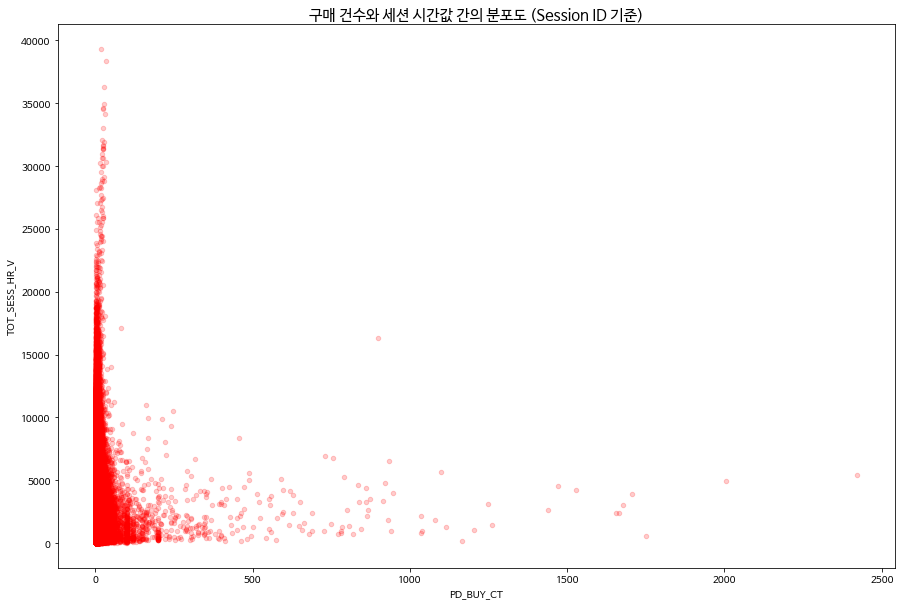

구매 건수와 세션 시간값 간의 상관관계: 0.067


In [15]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(x.replace(",","")))
data.plot(kind='scatter', x="PD_BUY_CT", y="TOT_SESS_HR_V", alpha=0.2, color='red',
         figsize=(15,10))
plt.title('구매 건수와 세션 시간값 간의 분포도 (Session ID 기준)', fontsize=15)
plt.show()
print("구매 건수와 세션 시간값 간의 상관관계: %.3f" %np.corrcoef(data['PD_BUY_CT'], data['TOT_SESS_HR_V'])[1,0])

구매카운트가 약 50 미만인 구간에서는 어느정도 양의 상관관계를 보이고 있다. 50 미만인 고객들만 선별하여 다시 살펴보자

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


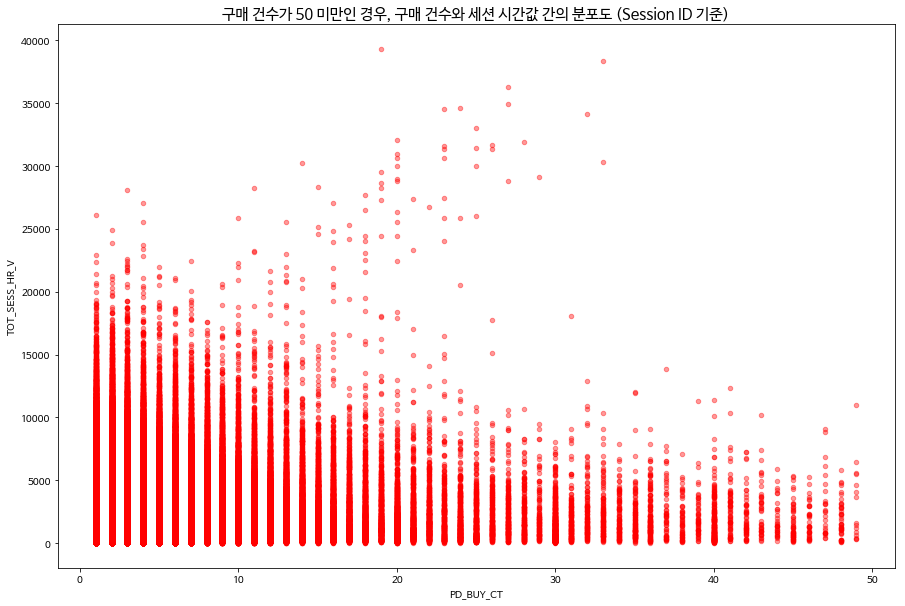

구매 건수와 세션 시간 값 간의 상관관계: 0.171


In [16]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<50]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(x.replace(',','')))
data.plot(kind='scatter', x='PD_BUY_CT', y='TOT_SESS_HR_V', alpha=0.4, color='red',
         figsize=(15,10))
plt.title("구매 건수가 50 미만인 경우, 구매 건수와 세션 시간값 간의 분포도 (Session ID 기준)", fontsize=15)
plt.show()

print('구매 건수와 세션 시간 값 간의 상관관계: %.3f' %np.corrcoef(data['TOT_SESS_HR_V'], data['PD_BUY_CT'])[1,0])

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


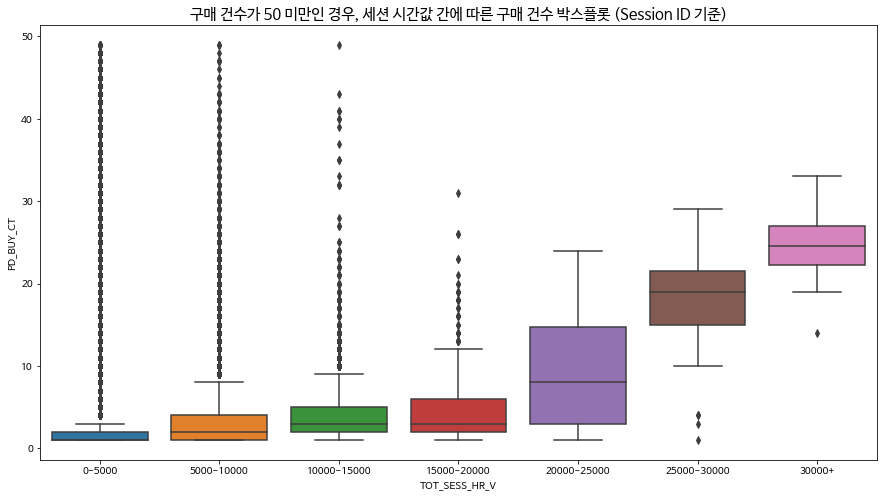

In [17]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<50]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(x.replace(',','')))
data['TOT_SESS_HR_V'] = pd.cut(data['TOT_SESS_HR_V'], [0, 5000,10000, 15000, 20000, 25000, 30000,10e+10],
                              labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000',
                                       '20000-25000', '25000-30000', '30000+'])
plt.figure(figsize=(15,8))
plt.title("구매 건수가 50 미만인 경우, 세션 시간값 간에 따른 구매 건수 박스플롯 (Session ID 기준)", fontsize=15)
sns.boxplot(x='TOT_SESS_HR_V', y='PD_BUY_CT', data=data)
plt.show()

구매 건수가 50 미만인 고객들을 대상으로 살펴본 총 세션 시간값과 어느 정도 정비례 하는 경향을 볼 수 있다.

# 기기 유형

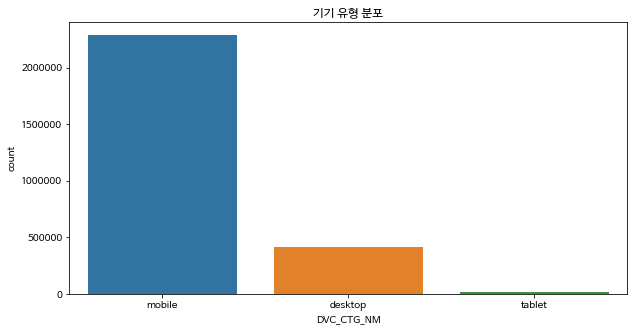

In [18]:
data =session['DVC_CTG_NM']
plt.figure(figsize=(10,5))
sns.countplot(data)
plt.title("기기 유형 분포")
plt.show()

In [19]:
data =session['DVC_CTG_NM']
print("mobile로는 총 %d 번, desktop로는 총 %d 번, tablet로는 총 %d 번의 거래가 이루어졌다." % ((data=='mobile').sum(), 
                                                                         (data=='desktop').sum(), (data=='tablet').sum()))

mobile로는 총 2289681 번, desktop로는 총 411169 번, tablet로는 총 12057 번의 거래가 이루어졌다.


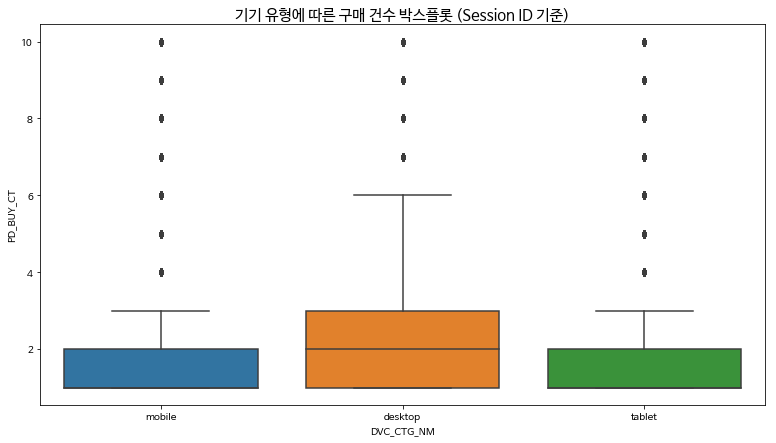

mobile 유저의 평균 구매 건수는 1.864522 건, desktop 유저의 평균 구매 건수는 2.337450 건, tablet 유저의 평균 구매 건수는 2.019525 건이다


In [20]:
data = buy_cnt_sess_merged[buy_cnt_sess_merged['PD_BUY_CT'] < buy_cnt_sess_merged['PD_BUY_CT'].quantile(0.99)]
plt.figure(figsize=(13,7))
sns.boxplot(x = 'DVC_CTG_NM', y = 'PD_BUY_CT', data=data)
plt.title("기기 유형에 따른 구매 건수 박스플롯 (Session ID 기준)", fontsize=15)
plt.show()
print("mobile 유저의 평균 구매 건수는 %f 건, desktop 유저의 평균 구매 건수는 %f 건, tablet 유저의 평균 구매 건수는 %f 건이다"\
      %(data[data['DVC_CTG_NM']=='mobile']['PD_BUY_CT'].mean(), data[data['DVC_CTG_NM']=='desktop']['PD_BUY_CT'].mean(),
       data[data['DVC_CTG_NM']=='tablet']['PD_BUY_CT'].mean()))

Desktop 유저가 가장 구매 건수가 높고, 그 다음으로 Tablet 유저, Mobile 유저 임을 알 수 있다.

# 지역대분류

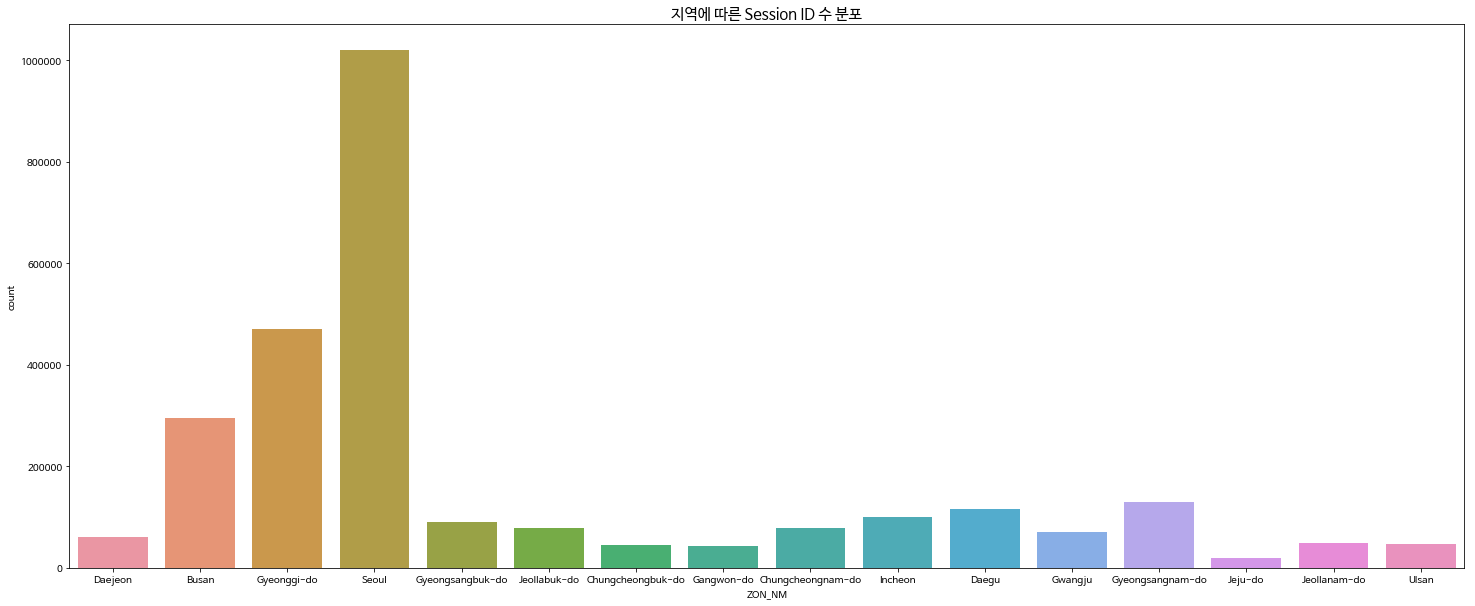

In [21]:
data =session['ZON_NM']
plt.figure(figsize=(25,10))
sns.countplot(data)
plt.title("지역에 따른 Session ID 수 분포", fontsize=15)
plt.show()

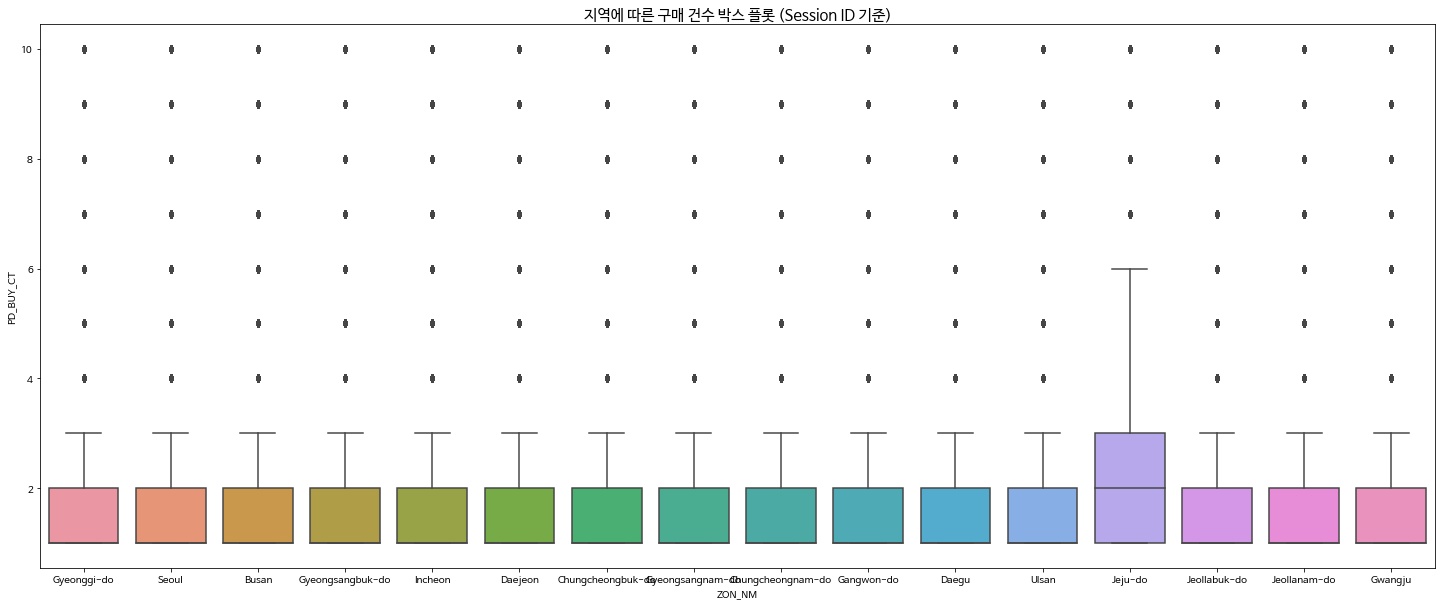

Gyeonggi-do 의 평균 구매 건수 : 1.952725 건
Seoul 의 평균 구매 건수 : 1.882643 건
Busan 의 평균 구매 건수 : 1.923000 건
Gyeongsangbuk-do 의 평균 구매 건수 : 2.003166 건
Incheon 의 평균 구매 건수 : 1.948814 건
Daejeon 의 평균 구매 건수 : 1.975351 건
Chungcheongbuk-do 의 평균 구매 건수 : 2.010937 건
Gyeongsangnam-do 의 평균 구매 건수 : 1.987385 건
Chungcheongnam-do 의 평균 구매 건수 : 2.026899 건
Gangwon-do 의 평균 구매 건수 : 2.000071 건
Daegu 의 평균 구매 건수 : 1.936361 건
Ulsan 의 평균 구매 건수 : 1.966541 건
Jeju-do 의 평균 구매 건수 : 2.123274 건
Jeollabuk-do 의 평균 구매 건수 : 2.015678 건
Jeollanam-do 의 평균 구매 건수 : 2.056949 건
Gwangju 의 평균 구매 건수 : 1.997154 건


In [22]:
data = buy_cnt_sess_merged[buy_cnt_sess_merged['PD_BUY_CT'] < buy_cnt_sess_merged['PD_BUY_CT'].quantile(0.99)]
plt.figure(figsize=(25,10))
plt.title("지역에 따른 구매 건수 박스 플롯 (Session ID 기준)", fontsize=15)
sns.boxplot(x = 'ZON_NM', y = 'PD_BUY_CT', data=data)
plt.show()

zon_list = data['ZON_NM'].unique()
for zon in zon_list:
    print("%s 의 평균 구매 건수 : %f 건" %(zon, data[data['ZON_NM']==zon]['PD_BUY_CT'].mean()))

의외로 평균 구매 건수가 가장 높은 지역은 제주도, 가장 낮은 지역은 서울인 것으로 드러났다. 지역별 1인당 gdp가 가장 큰 곳이 서울인 것을 감안할 때 예상 밖의 결과라고 할 수 있다. 과연 구매 건수말고 구매 총액에서도 그럴지 알아보겠다.

In [23]:
product['PD_BUY_AM'] = product['PD_BUY_AM'].apply(lambda x: int(x.replace(',','')))
buy_amnt_sess = product[['CLNT_ID', 'SESS_ID', 'PD_BUY_AM']].groupby(['CLNT_ID', 'SESS_ID'], as_index=False).sum()
buy_amnt_sess_merged = buy_amnt_sess.merge(session, on=['CLNT_ID', 'SESS_ID'], how='left')

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


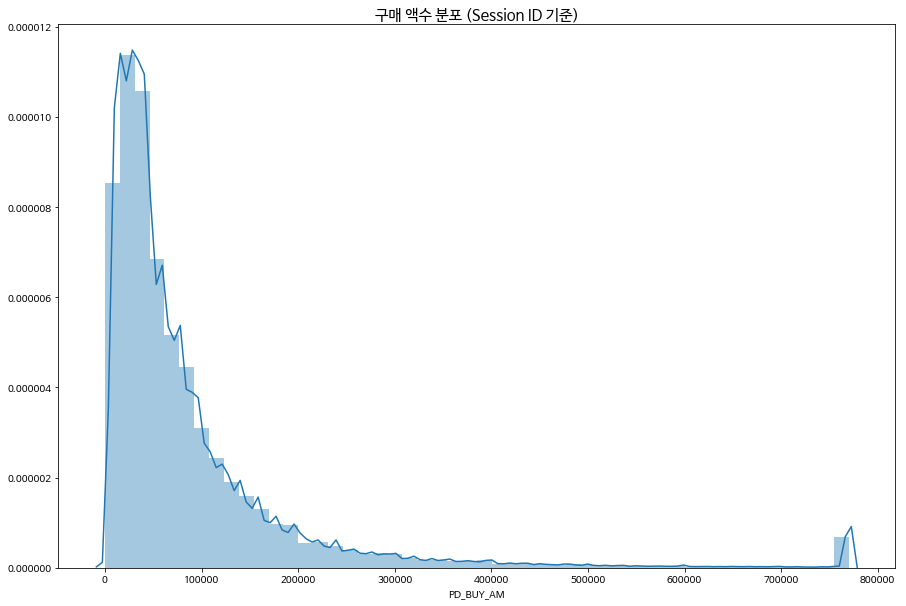

In [24]:
data = buy_amnt_sess_merged['PD_BUY_AM']
data[data>data.quantile(0.99)] = data.quantile(0.99)
plt.figure(figsize = (15,10))
plt.title("구매 액수 분포 (Session ID 기준)", fontsize=15)
sns.distplot(data)
plt.show()

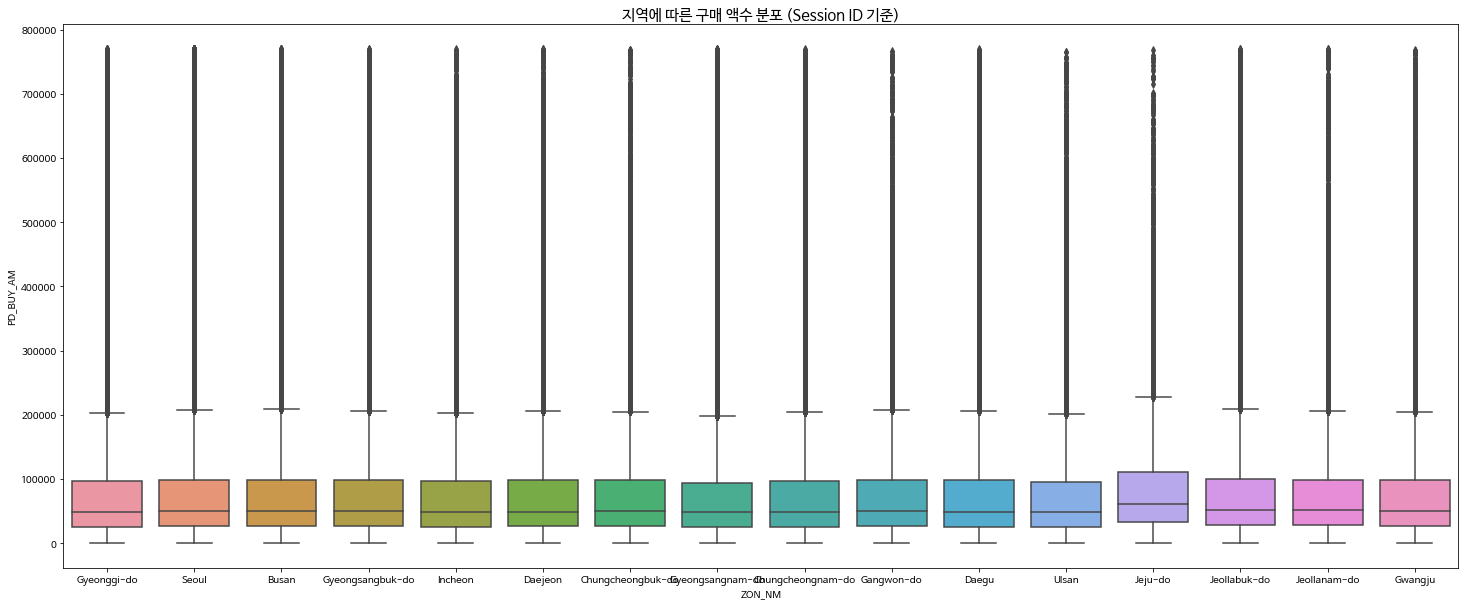

Gyeonggi-do 의 평균 구매 액수 : 78505.027784 원
Seoul 의 평균 구매 액수 : 81704.804206 원
Busan 의 평균 구매 액수 : 80632.557025 원
Gyeongsangbuk-do 의 평균 구매 액수 : 79507.467060 원
Incheon 의 평균 구매 액수 : 78115.244429 원
Daejeon 의 평균 구매 액수 : 79798.480831 원
Chungcheongbuk-do 의 평균 구매 액수 : 80562.354516 원
Gyeongsangnam-do 의 평균 구매 액수 : 76391.426167 원
Chungcheongnam-do 의 평균 구매 액수 : 78943.533281 원
Gangwon-do 의 평균 구매 액수 : 80426.189193 원
Daegu 의 평균 구매 액수 : 79037.191515 원
Ulsan 의 평균 구매 액수 : 77372.076740 원
Jeju-do 의 평균 구매 액수 : 91652.067415 원
Jeollabuk-do 의 평균 구매 액수 : 82773.261503 원
Jeollanam-do 의 평균 구매 액수 : 80875.614974 원
Gwangju 의 평균 구매 액수 : 80234.224970 원


In [25]:
data = buy_amnt_sess_merged[buy_amnt_sess_merged['PD_BUY_AM'] < buy_amnt_sess_merged['PD_BUY_AM'].quantile(0.99)]
plt.figure(figsize=(25,10))
sns.boxplot(x = 'ZON_NM', y = 'PD_BUY_AM', data=data)
plt.title("지역에 따른 구매 액수 분포 (Session ID 기준)", fontsize=15)
plt.show()

zon_list = data['ZON_NM'].unique()
for zon in zon_list:
    print("%s 의 평균 구매 액수 : %f 원" %(zon, data[data['ZON_NM']==zon]['PD_BUY_AM'].mean()))

지역마다 큰 차이가 거의 없는 반면에 제주도는 비교적 높은 것을 알 수 있다. 제주도의 구매 성향을 파악해보자

# 제주도의 구매 성향 파악하기

In [26]:
master = pd.read_csv(data_dir + 'master.csv')
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847652 entries, 0 to 847651
Data columns (total 5 columns):
PD_C        847652 non-null int64
PD_NM       847652 non-null object
CLAC1_NM    847652 non-null object
CLAC2_NM    847652 non-null object
CLAC3_NM    847652 non-null object
dtypes: int64(1), object(4)
memory usage: 32.3+ MB


In [27]:
prod_mas = product.merge(master, on='PD_C', how='left')
prod_mas_sess = prod_mas.merge(session, how='left', on=['CLNT_ID', 'SESS_ID'])
prod_mas_sess.isnull().sum()

CLNT_ID                0
SESS_ID                0
HITS_SEQ               0
PD_C                   0
PD_ADD_NM              0
PD_BRA_NM              0
PD_BUY_AM              0
PD_BUY_CT              0
PD_NM                  0
CLAC1_NM               0
CLAC2_NM               0
CLAC3_NM               0
SESS_SEQ               0
SESS_DT                0
TOT_PAG_VIEW_CT      435
TOT_SESS_HR_V      20320
DVC_CTG_NM             0
ZON_NM                 0
CITY_NM                0
dtype: int64

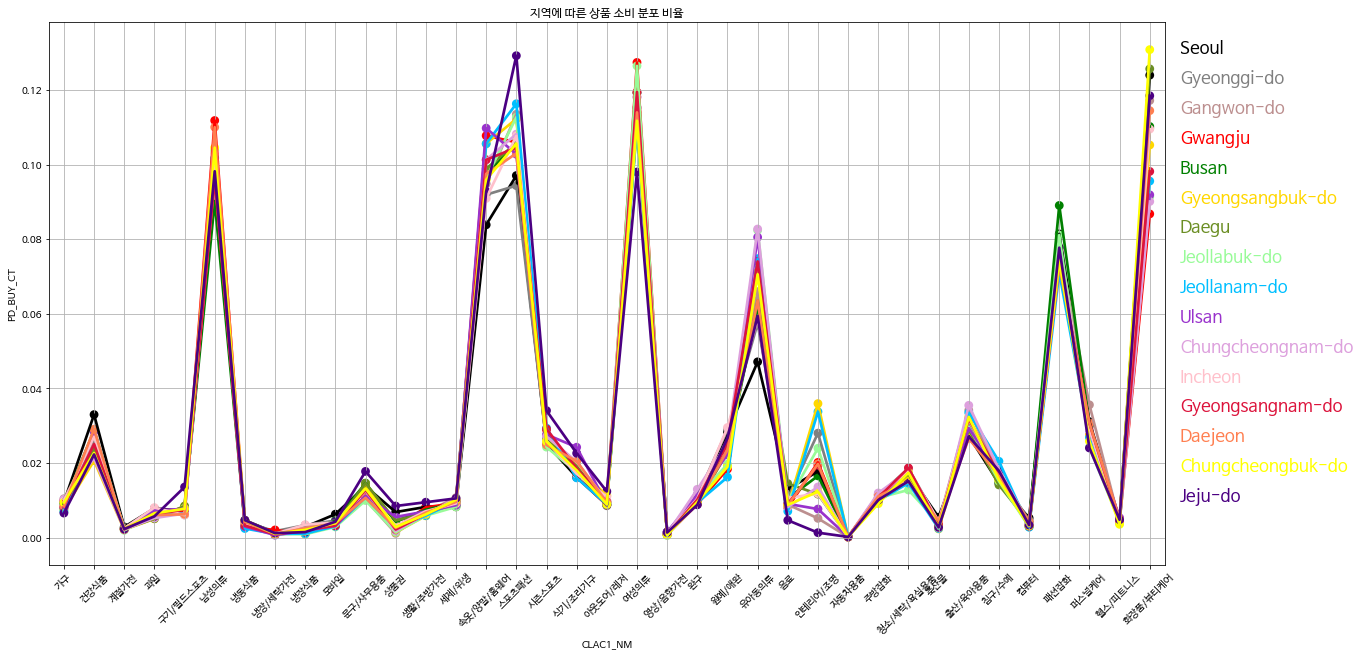

In [28]:
f,ax1 = plt.subplots(figsize =(20,10))
zone_list = prod_mas_sess['ZON_NM'].unique()
color_list = ['black','gray','rosybrown','red','green','gold','olivedrab','palegreen','deepskyblue',
              'darkorchid','plum','pink', 'crimson', 'coral', 'yellow', 'indigo', 'orchid', 'pink'][:len(zone_list)]

plt.title("지역에 따른 상품 소비 분포 비율",)
plt.xticks(rotation=45)
for i in range(len(zone_list)):
    data = prod_mas_sess[prod_mas_sess['ZON_NM'] == zone_list[i]][['CLAC1_NM', 'PD_BUY_CT']].groupby('CLAC1_NM',as_index=False).sum()
    data['PD_BUY_CT'] = data['PD_BUY_CT']/data['PD_BUY_CT'].sum()
    sns.pointplot(x='CLAC1_NM',y='PD_BUY_CT',data=data, color=color_list[i],alpha=0.8)
for i in range(len(zone_list)):
    plt.text(37, 0.13-0.008*i, zone_list[i],color=color_list[i],fontsize = 17,style = 'italic')
plt.grid()
plt.show()

제주도는 스포츠 패션에 대한 구매가 타 지역에 비해 상당히 높음을 알 수 있다. 한편 인테리어나 건강식품, 여성의류, 패션잡화 등에서는 낮은 수치를 보였다.

# Desktop 유저들의 구매 성향 파악하기

In [29]:
product.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,4139680,7605037,12,642112,색상:워터멜론,[바비브라운],39000,1
1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK|사이즈:120 / 2개,데상트,39000,2
2,4142395,6158159,85,179538,(not set),[아베다],39000,1
3,4144914,7935714,12,554336,색상:블랙|사이즈:160cm(12~13세) / 1개,아디다스 키즈,39000,1
4,4144917,6406509,78,190306,5개,데코르테,39000,5


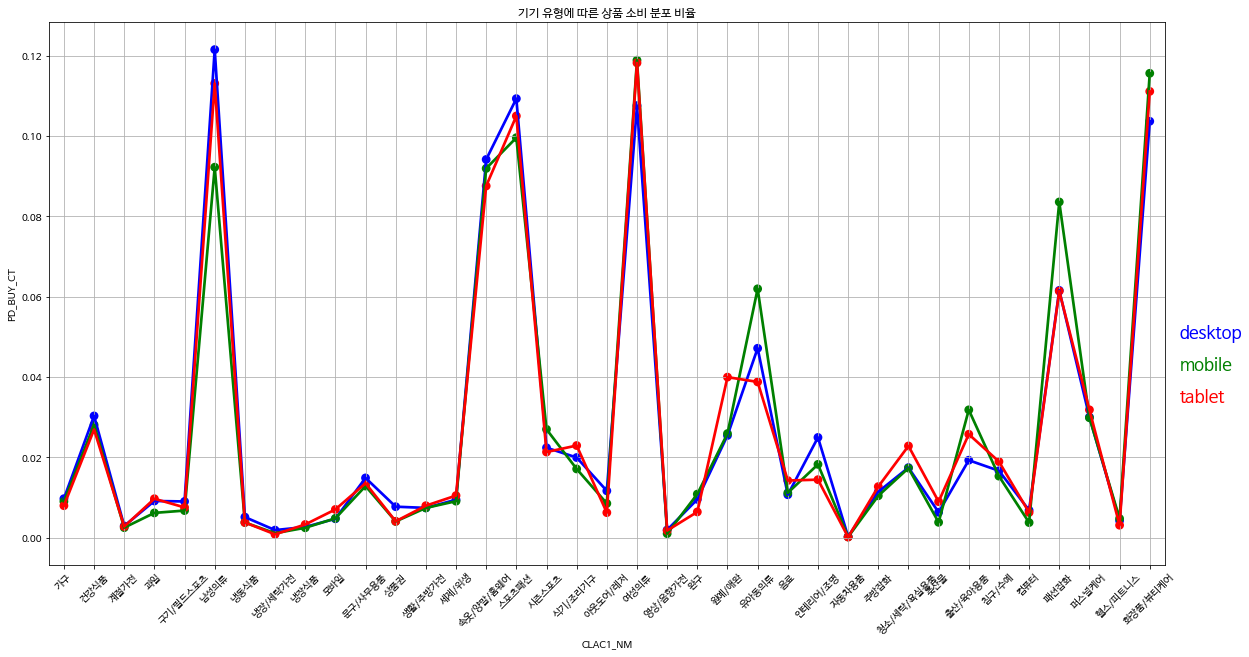

In [30]:
data = product[['CLNT_ID', 'SESS_ID', 'PD_C', 'PD_BUY_CT']].merge(master, on='PD_C', how='left')\
.merge(session[['CLNT_ID', 'SESS_ID','DVC_CTG_NM']], how='left', on=['CLNT_ID','SESS_ID'] )

plt.figure(figsize =(20,10))
device_list = data['DVC_CTG_NM'].unique()
color_list = ['blue','green','red']

plt.title("기기 유형에 따른 상품 소비 분포 비율")
plt.xticks(rotation=45)
for i in range(len(device_list)):
    data_mini = data[data['DVC_CTG_NM'] == device_list[i]][['CLAC1_NM', 'PD_BUY_CT']].groupby('CLAC1_NM',as_index=False).sum()
    data_mini['PD_BUY_CT'] = data_mini['PD_BUY_CT']/data_mini['PD_BUY_CT'].sum()
    sns.pointplot(x='CLAC1_NM',y='PD_BUY_CT',data=data_mini, color=color_list[i],alpha=0.8)
for i in range(len(device_list)):
    plt.text(37, 0.05-0.008*i, device_list[i],color=color_list[i],fontsize = 17,style = 'italic')
plt.grid()
plt.show()

데스크탑은 남성의류, 스포츠에 대한 구매가 매우 높은 반면에 유아동의류, 육아용품, 패션잡화 등에서는 매우 낮은 구매율을 보이고 있다.

제주도 구매자의 경우나, 지금 데스크탑 구매자의 경우나 모두 스포츠 의류를 많이 산다는 공통점이 있다. 왜 스포츠 의류를 많이 찾는 집단에서는 평균적으로 높은 구매 건수를 보이는걸까? 스포츠 의류를 주로 찾는 고객들이 어떤 특성을 보이는지 좀더 자세히 살펴보자. 추가적으로 제주도에서 평균이상, 데스크탑에서는 현저하게 높은 구매율을 보인 남성의류에 대해서도 살펴보자. 

# 스포츠 패션, 남성 의류 구매 고객들의 성별과 연령대

In [32]:
custom = pd.read_csv(data_dir + 'custom.csv')

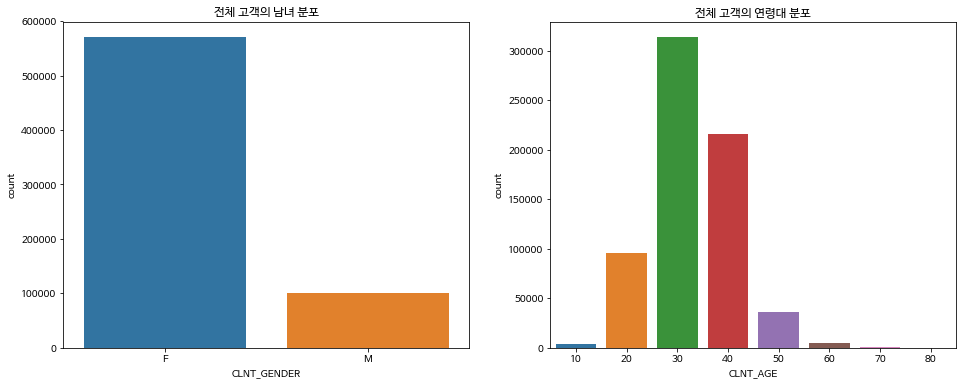

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(custom['CLNT_GENDER'],ax=ax[0])
ax[0].set_title('전체 고객의 남녀 분포')
sns.countplot(custom['CLNT_AGE'], ax=ax[1])
ax[1].set_title('전체 고객의 연령대 분포')
plt.show()

In [34]:
prod_mas_cus = prod_mas.merge(custom, on='CLNT_ID', how='left')

In [35]:
prod_mas_cus.isnull().sum()

CLNT_ID              0
SESS_ID              0
HITS_SEQ             0
PD_C                 0
PD_ADD_NM            0
PD_BRA_NM            0
PD_BUY_AM            0
PD_BUY_CT            0
PD_NM                0
CLAC1_NM             0
CLAC2_NM             0
CLAC3_NM             0
CLNT_GENDER    1036319
CLNT_AGE       1036319
dtype: int64

In [36]:
prod_mas_cus.dropna(inplace=True)

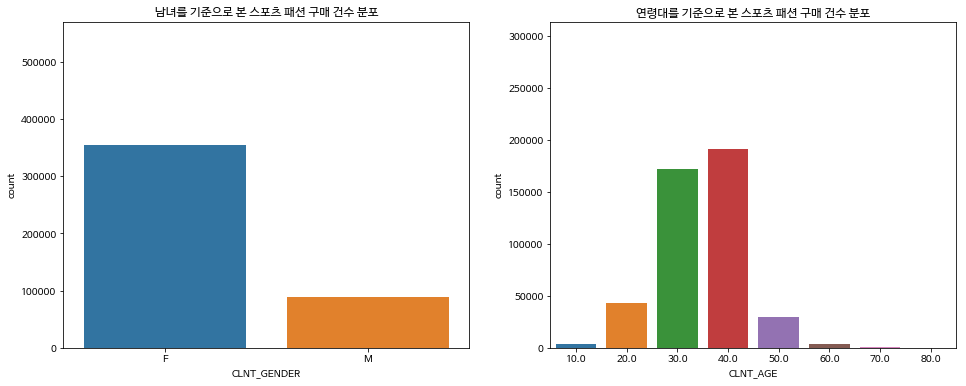

In [37]:
data = prod_mas_cus[prod_mas_cus['CLAC1_NM'] == '스포츠패션']
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].set_title("남녀를 기준으로 본 스포츠 패션 구매 건수 분포")
sns.countplot(data['CLNT_GENDER'], ax=ax[0])
ax[0].set_ylim(0, (custom['CLNT_GENDER']=='F').sum())

ax[1].set_title("연령대를 기준으로 본 스포츠 패션 구매 건수 분포")
sns.countplot(data['CLNT_AGE'], ax=ax[1])
ax[1].set_ylim(0, (custom['CLNT_AGE']==30).sum())
plt.show()

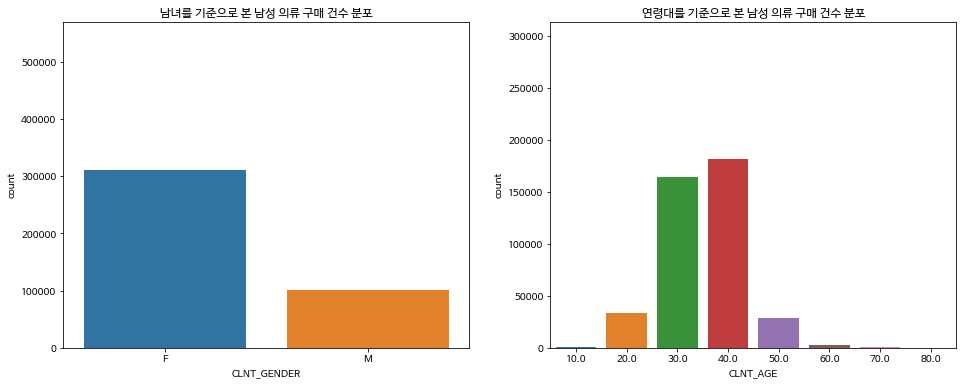

In [59]:
data = prod_mas_cus[prod_mas_cus['CLAC1_NM'] == '남성의류']
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].set_title("남녀를 기준으로 본 남성 의류 구매 건수 분포")
sns.countplot(data['CLNT_GENDER'], ax=ax[0], order=['F', 'M'])
ax[0].set_ylim(0, (custom['CLNT_GENDER']=='F').sum())

ax[1].set_title("연령대를 기준으로 본 남성 의류 구매 건수 분포")
sns.countplot(data['CLNT_AGE'], ax=ax[1])
ax[1].set_ylim(0, (custom['CLNT_AGE']==30).sum())
plt.show()

스포츠 패션과 남성의류 구매 기록을 보니 모두 남성과 40대의 비율이 확연히 높음을 알 수 있다.

# 스포츠 패션, 남성의류 구매 고객들의 지역 정보

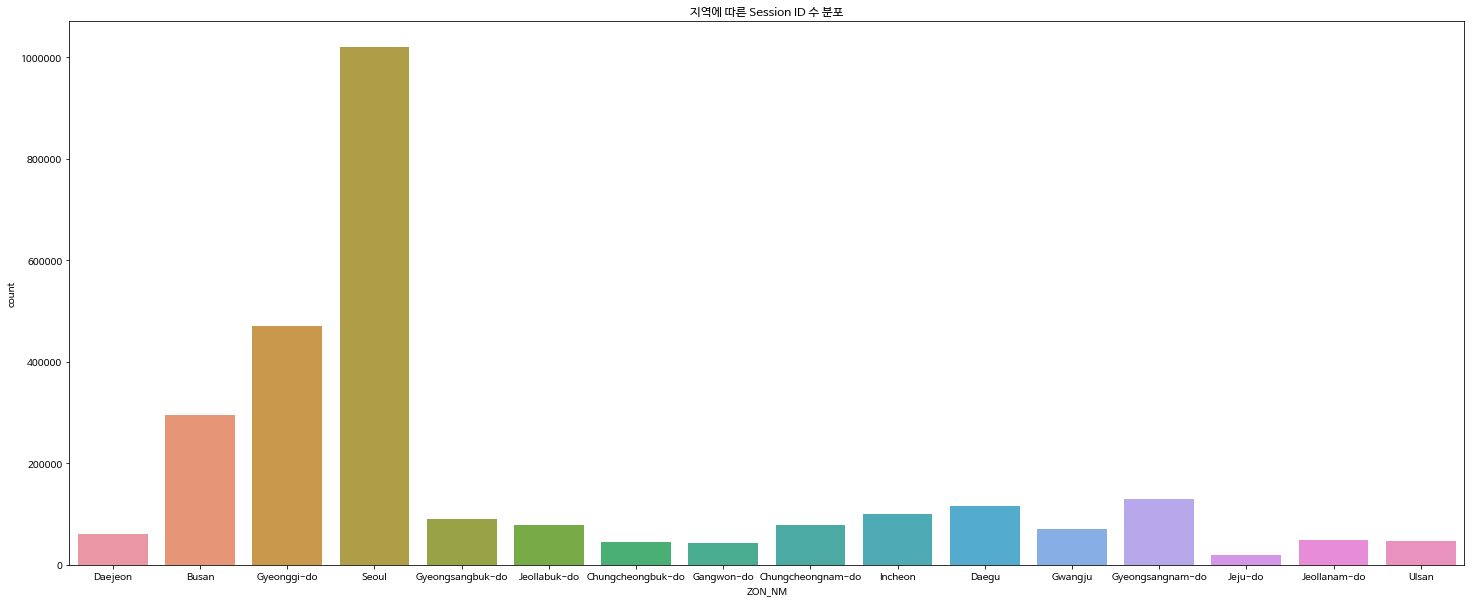

In [38]:
data =session['ZON_NM']
plt.figure(figsize=(25,10))
sns.countplot(data)
plt.title("지역에 따른 Session ID 수 분포")
plt.show()

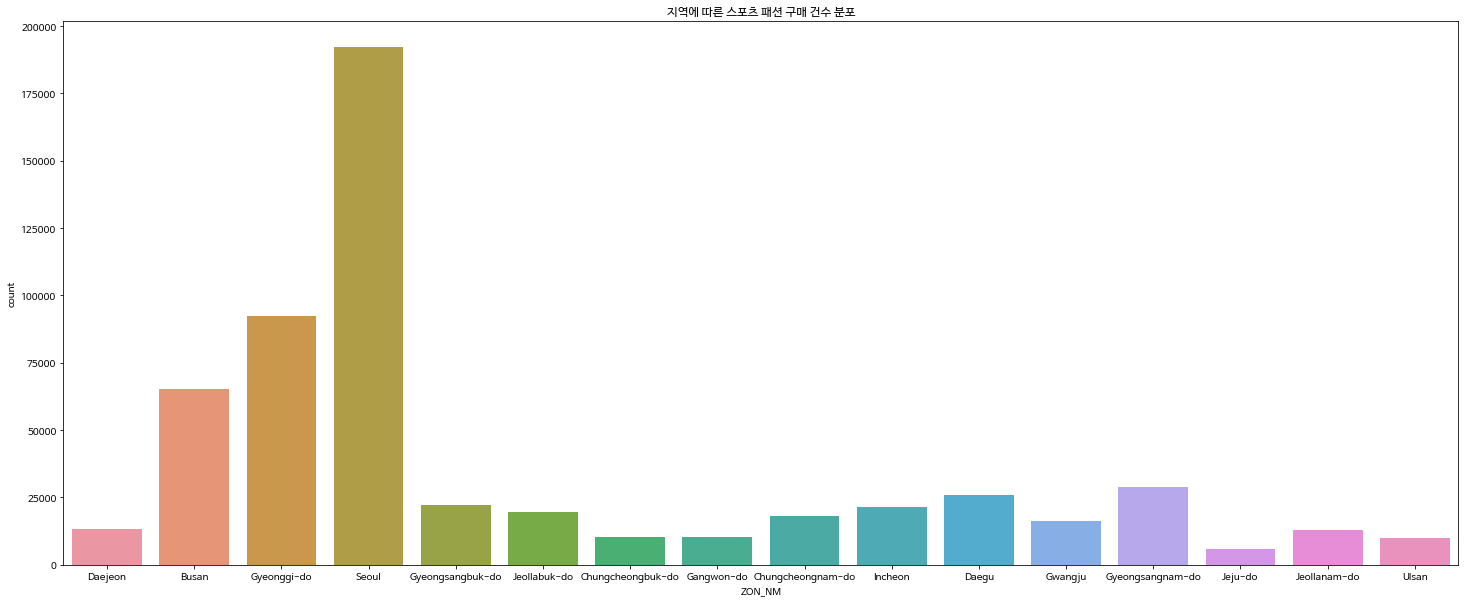

In [39]:
data = prod_mas_sess[prod_mas_sess['CLAC1_NM']=='스포츠패션']
plt.figure(figsize=(25,10))
plt.title("지역에 따른 스포츠 패션 구매 건수 분포")
x_order = ['Daejeon', 'Busan', 'Gyeonggi-do', 'Seoul', 'Gyeongsangbuk-do', 'Jeollabuk-do', 'Chungcheongbuk-do', 'Gangwon-do',
          'Chungcheongnam-do', 'Incheon', 'Daegu', 'Gwangju', 'Gyeongsangnam-do', 'Jeju-do', 'Jeollanam-do', 'Ulsan']
sns.countplot(data['ZON_NM'], order=x_order)
plt.show()

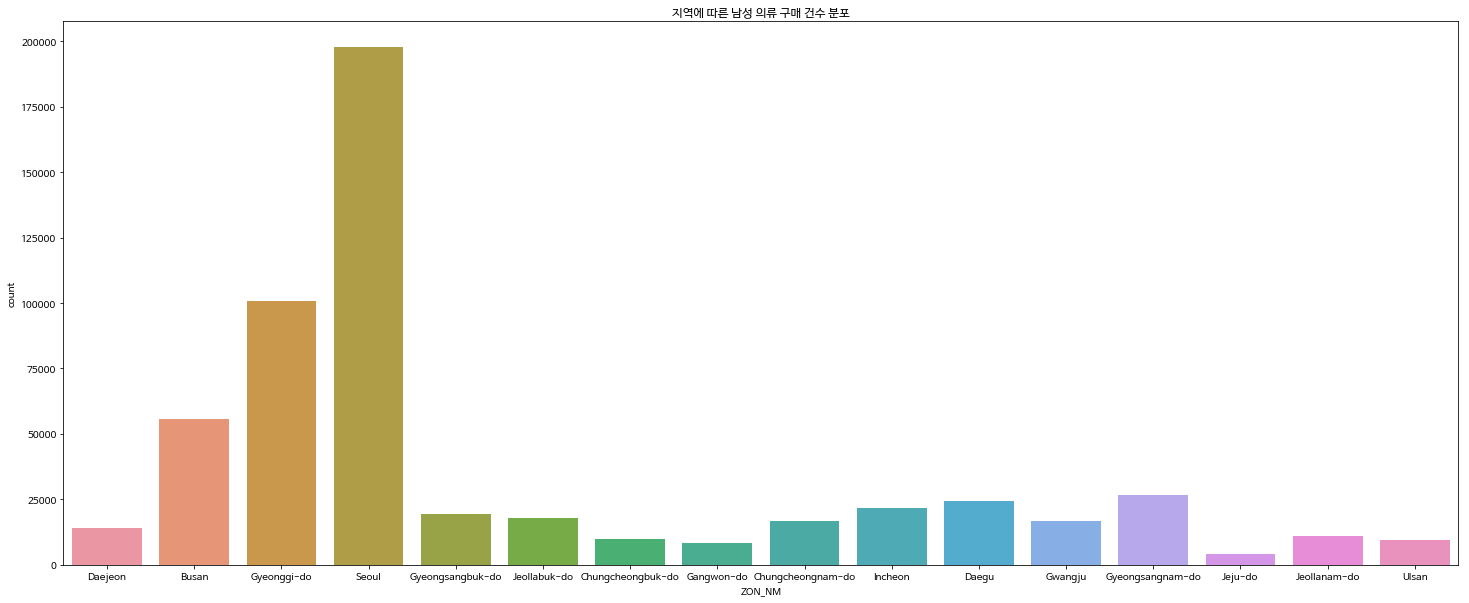

In [58]:
data = prod_mas_sess[prod_mas_sess['CLAC1_NM']=='남성의류']
plt.figure(figsize=(25,10))
plt.title("지역에 따른 남성 의류 구매 건수 분포")
x_order = ['Daejeon', 'Busan', 'Gyeonggi-do', 'Seoul', 'Gyeongsangbuk-do', 'Jeollabuk-do', 'Chungcheongbuk-do', 'Gangwon-do',
          'Chungcheongnam-do', 'Incheon', 'Daegu', 'Gwangju', 'Gyeongsangnam-do', 'Jeju-do', 'Jeollanam-do', 'Ulsan']
sns.countplot(data['ZON_NM'], order=x_order)
plt.show()

지역 분포는 스포츠 패션과 남성 의류 모두 전체 고객의 분포와 거의 차이가 없음을 알 수 있다.

# 스포츠 패션, 남성 의류 구매 고객들의 총 세션 시간 값

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

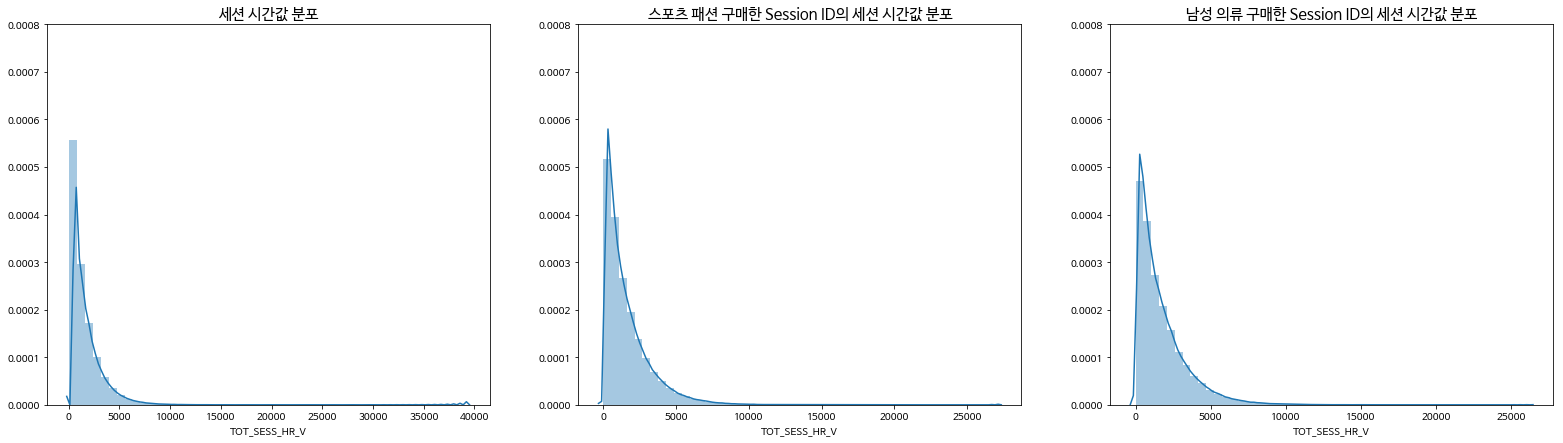

In [60]:
f, ax = plt.subplots(1, 3, figsize = (27,7))

data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(str(x).replace(',','')))
ax[0].set_title("세션 시간값 분포", fontsize=15)
ax[0].set_ylim(0, 0.0008)
sns.distplot(data['TOT_SESS_HR_V'], ax=ax[0])

data = prod_mas_sess[prod_mas_sess['CLAC1_NM']=='스포츠패션']
data.dropna(inplace=True) # na 약 2307개 존재 
data = data[['CLNT_ID', 'SESS_ID', 'TOT_SESS_HR_V']].groupby(['CLNT_ID', 'SESS_ID']).first()
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(str(x).replace(',','')))
ax[1].set_title("스포츠 패션 구매한 Session ID의 세션 시간값 분포", fontsize=15)
ax[1].set_ylim(0, 0.0008)
sns.distplot(data['TOT_SESS_HR_V'], ax=ax[1])

data = prod_mas_sess[prod_mas_sess['CLAC1_NM']=='남성의류']
data.dropna(inplace=True) # na 약 2307개 존재 
data = data[['CLNT_ID', 'SESS_ID', 'TOT_SESS_HR_V']].groupby(['CLNT_ID', 'SESS_ID']).first()
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(str(x).replace(',','')))
ax[2].set_title("남성 의류 구매한 Session ID의 세션 시간값 분포", fontsize=15)
ax[2].set_ylim(0, 0.0008)
sns.distplot(data['TOT_SESS_HR_V'], ax=ax[2])

plt.show()

스포츠 패션, 남성 의류를 구매한 경우 세션 시간 값이 전체 분포에 비해 전체적으로 높음을 알 수 있다. 즉 스포츠 패션이나 남성 의류를 구매하는 고객들일수록 홈페이지 접속 시간이 전반적으로 길다는 의미다.

# 스포츠 패션, 남성 의류 고객들의 총페이지 조회 건수

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

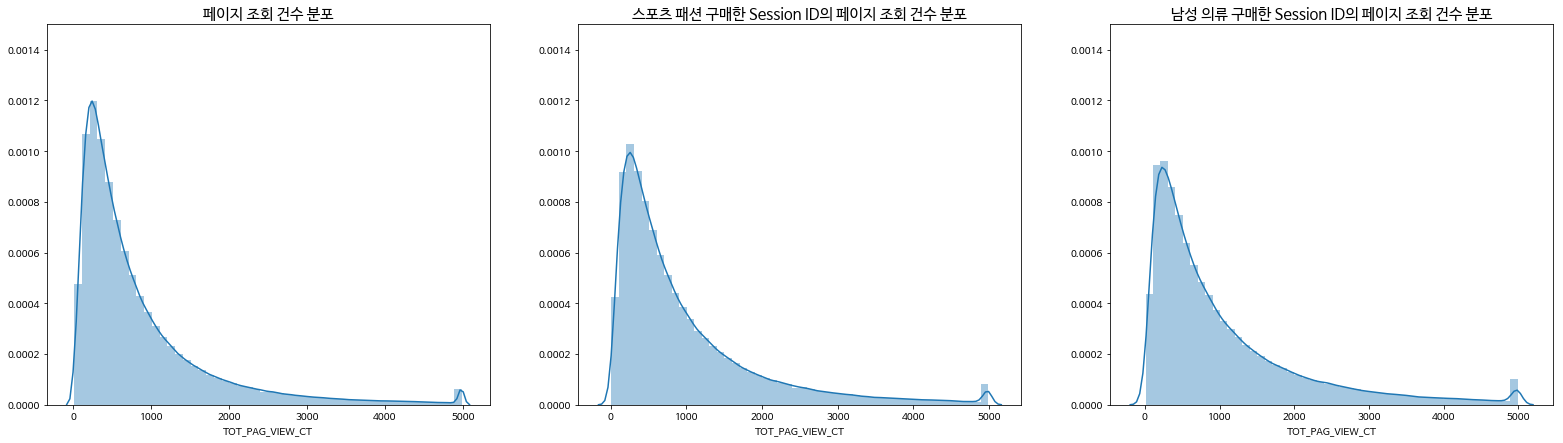

In [61]:
f, ax = plt.subplots(1, 3, figsize = (27,7))

data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_PAG_VIEW_CT'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<50]
data['TOT_PAG_VIEW_CT'] = data['TOT_PAG_VIEW_CT'].apply(lambda x: int(str(x).replace('.','')))
ax[0].set_title("페이지 조회 건수 분포", fontsize=15)
ax[0].set_ylim(0, 0.0015)
sns.distplot(data['TOT_PAG_VIEW_CT'], ax=ax[0])

data = prod_mas_sess[prod_mas_sess['CLAC1_NM']=='스포츠패션']
data.dropna(inplace=True) # na 약 2307개 존재 
data = data[['CLNT_ID', 'SESS_ID', 'TOT_PAG_VIEW_CT']].groupby(['CLNT_ID', 'SESS_ID']).first()
data['TOT_PAG_VIEW_CT'] = data['TOT_PAG_VIEW_CT'].apply(lambda x: int(str(x).replace('.','')))
ax[1].set_title("스포츠 패션 구매한 Session ID의 페이지 조회 건수 분포", fontsize=15)
ax[1].set_ylim(0, 0.0015)
sns.distplot(data['TOT_PAG_VIEW_CT'], ax=ax[1])

data = prod_mas_sess[prod_mas_sess['CLAC1_NM']=='남성의류']
data.dropna(inplace=True) # na 약 2307개 존재 
data = data[['CLNT_ID', 'SESS_ID', 'TOT_PAG_VIEW_CT']].groupby(['CLNT_ID', 'SESS_ID']).first()
data['TOT_PAG_VIEW_CT'] = data['TOT_PAG_VIEW_CT'].apply(lambda x: int(str(x).replace('.','')))
ax[2].set_title("남성 의류 구매한 Session ID의 페이지 조회 건수 분포", fontsize=15)
ax[2].set_ylim(0, 0.0015)
sns.distplot(data['TOT_PAG_VIEW_CT'], ax=ax[2])

plt.show()

스포츠 패션, 남성 의류를 구매한 경우 페이지 조회 건수가 전체 분포에 비해 전반적으로 높음을 알 수 있다. 즉 스포츠 패션이나 남성 의류를 구매하는 고객일수록 페이지를 더 많이 조회해보는 경향이 있다는 의미다.

# 스포츠 패션, 남성 의류 고객들의 검색량

In [45]:
search_1 = pd.read_csv(data_dir + 'Search1.csv')
search_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884943 entries, 0 to 2884942
Data columns (total 4 columns):
CLNT_ID       int64
SESS_ID       int64
KWD_NM        object
SEARCH_CNT    int64
dtypes: int64(3), object(1)
memory usage: 88.0+ MB


In [46]:
search_1_sess = search_1[['CLNT_ID', 'SESS_ID', 'SEARCH_CNT']].groupby(['CLNT_ID', 'SESS_ID'], as_index=False).sum()
prod_mass_sess_search1 = prod_mas_sess.merge(search_1_sess, how='left', on=['CLNT_ID', 'SESS_ID'])
prod_mass_sess_search1.dropna(inplace=True)
prod_mass_sess_search1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2438751 entries, 2 to 5024904
Data columns (total 20 columns):
CLNT_ID            int64
SESS_ID            int64
HITS_SEQ           int64
PD_C               int64
PD_ADD_NM          object
PD_BRA_NM          object
PD_BUY_AM          int64
PD_BUY_CT          int64
PD_NM              object
CLAC1_NM           object
CLAC2_NM           object
CLAC3_NM           object
SESS_SEQ           int64
SESS_DT            int64
TOT_PAG_VIEW_CT    float64
TOT_SESS_HR_V      object
DVC_CTG_NM         object
ZON_NM             object
CITY_NM            object
SEARCH_CNT         float64
dtypes: float64(2), int64(8), object(10)
memory usage: 390.7+ MB


C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


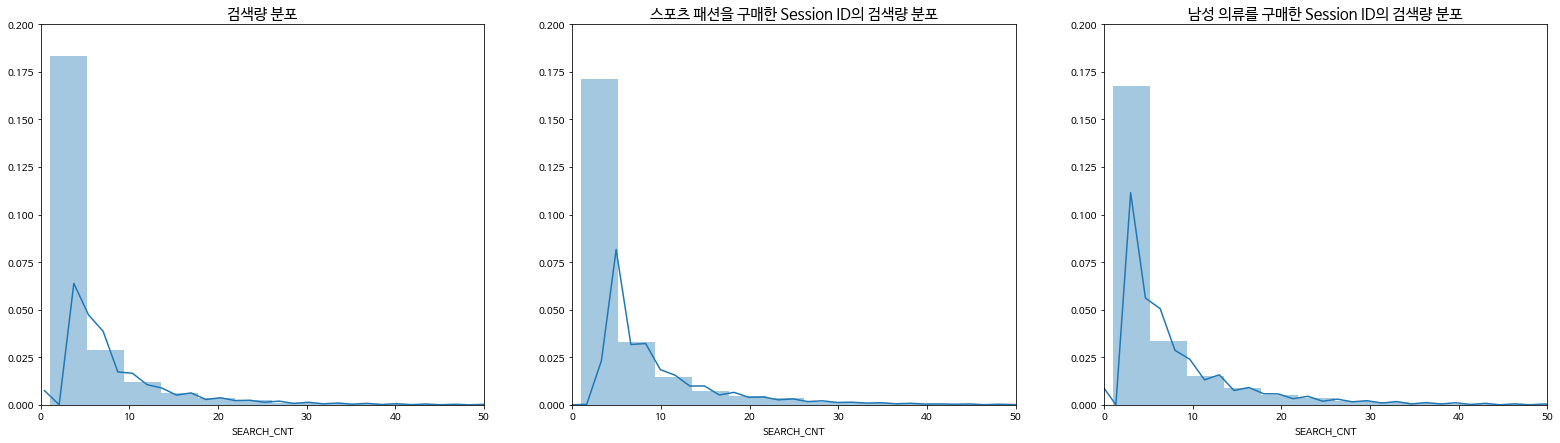

In [62]:
f, ax = plt.subplots(1, 3, figsize = (27,7))

data = search_1_sess
ax[0].set_title("검색량 분포", fontsize=15)
ax[0].set_xlim(0,50)
ax[0].set_ylim(0, 0.2)
sns.distplot(data['SEARCH_CNT'], ax=ax[0])

data = prod_mass_sess_search1[prod_mass_sess_search1['CLAC1_NM']=='스포츠패션']
data = data[['CLNT_ID', 'SESS_ID', 'SEARCH_CNT']].groupby(['CLNT_ID', 'SESS_ID']).first()
data['SEARCH_CNT'] = data['SEARCH_CNT'].apply(lambda x: int(x))
ax[1].set_title("스포츠 패션을 구매한 Session ID의 검색량 분포", fontsize=15)
ax[1].set_xlim(0,50)
ax[1].set_ylim(0, 0.2)
sns.distplot(data['SEARCH_CNT'], ax=ax[1])

data = prod_mass_sess_search1[prod_mass_sess_search1['CLAC1_NM']=='남성의류']
data = data[['CLNT_ID', 'SESS_ID', 'SEARCH_CNT']].groupby(['CLNT_ID', 'SESS_ID']).first()
data['SEARCH_CNT'] = data['SEARCH_CNT'].apply(lambda x: int(x))
ax[2].set_title("남성 의류를 구매한 Session ID의 검색량 분포", fontsize=15)
ax[2].set_xlim(0,50)
ax[2].set_ylim(0, 0.2)
sns.distplot(data['SEARCH_CNT'], ax=ax[2])

plt.show()

검색량은 스포츠 패션, 남성의류를 구매한 고객이 전체 고객보다 검색량도 조금더 많은 경향을 볼 수 있다. 다만 큰 차이는 보이지 않는다.

# 스포츠 패션, 남성 의류 고객들의 단어 검색 워드 클라우드

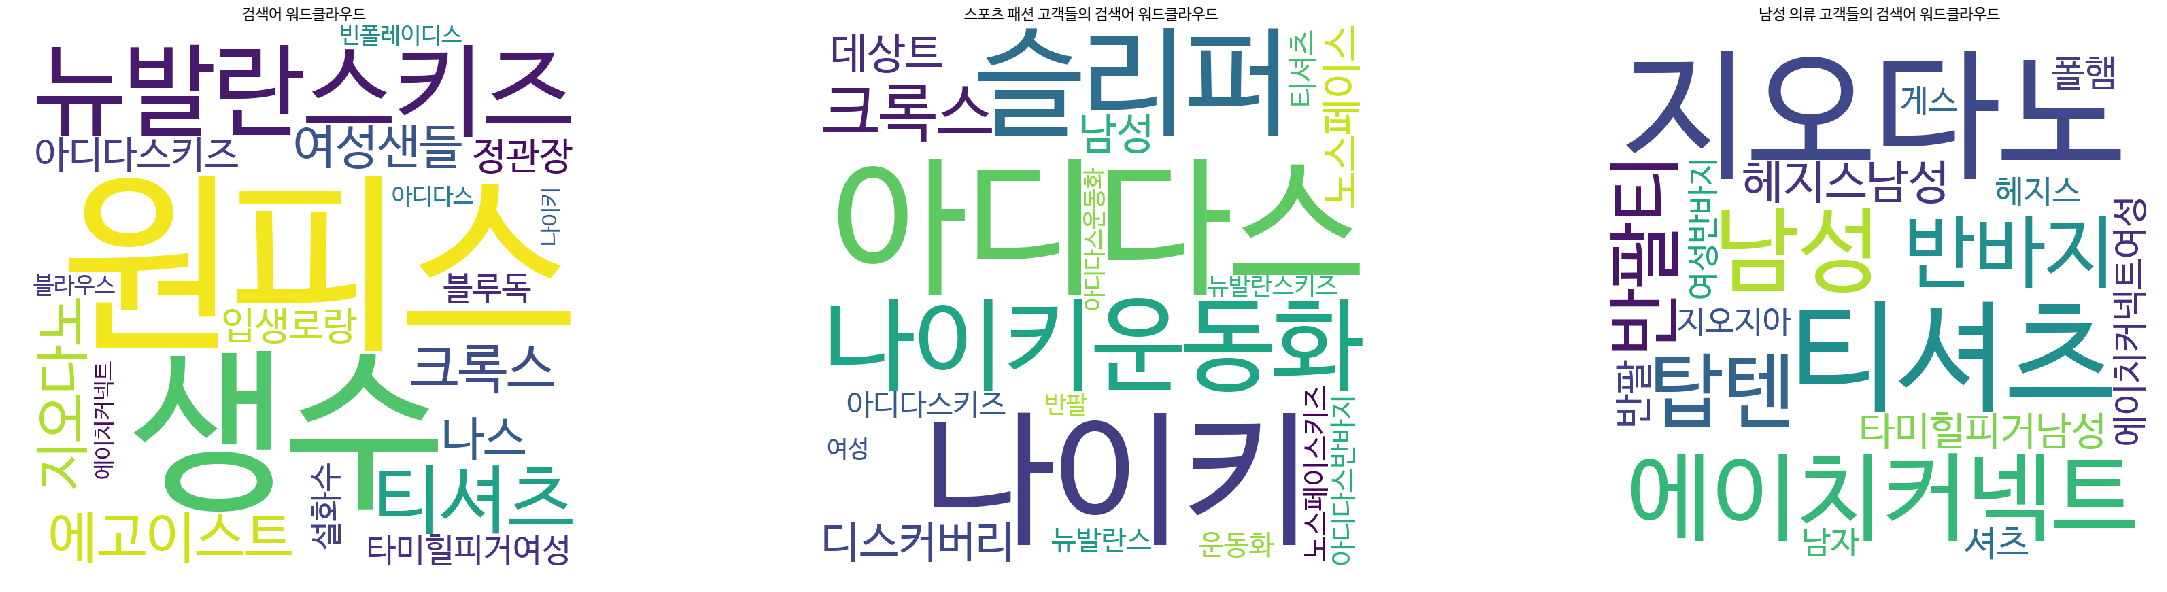

In [63]:
def getting_top_keywords(data, n):
    dic = dict(Counter(data))
    arr = np.array(list(dic.values()))
    top_idx = np.argsort(arr)[::-1][:n]
    return np.array(list(dic.keys()))[top_idx]

f, ax = plt.subplots(1, 3, figsize = (40,10))
n = 20

data = search_1
top_words = getting_top_keywords(data['KWD_NM'], n)
data = data['KWD_NM'][data['KWD_NM'].isin(top_words)]
wordcloud = WordCloud(font_path = 'c:\\windows\\fonts\\NanumBarunGothic.ttf' ,
                      width = 800, height = 800, max_words=100000,
                        background_color ='white',  collocations = False,
                        min_font_size = 10).generate(" ".join(data)) 
ax[0].imshow(wordcloud) 
ax[0].set_title("검색어 워드클라우드", fontsize=15)
ax[0].axis('off')


data = prod_mas.merge(search_1, on=['CLNT_ID', 'SESS_ID'], how='left')
data = data[data['CLAC1_NM'] == '스포츠패션']
data.dropna(inplace=True)
top_words = getting_top_keywords(data['KWD_NM'], n)
data = data['KWD_NM'][data['KWD_NM'].isin(top_words)]
wordcloud = WordCloud(font_path = 'c:\\windows\\fonts\\NanumBarunGothic.ttf' ,
                      width = 800, height = 800, max_words=100000,
                        background_color ='white', collocations = False,
                        min_font_size = 10).generate(" ".join(data)) 
ax[1].imshow(wordcloud) 
ax[1].set_title("스포츠 패션 고객들의 검색어 워드클라우드", fontsize=15)
ax[1].axis('off')

data = prod_mas.merge(search_1, on=['CLNT_ID', 'SESS_ID'], how='left')
data = data[data['CLAC1_NM'] == '남성의류']
data.dropna(inplace=True)
top_words = getting_top_keywords(data['KWD_NM'], n)
data = data['KWD_NM'][data['KWD_NM'].isin(top_words)]
wordcloud = WordCloud(font_path = 'c:\\windows\\fonts\\NanumBarunGothic.ttf' ,
                      width = 800, height = 800, max_words=100000,
                        background_color ='white', collocations = False,
                        min_font_size = 10).generate(" ".join(data)) 
ax[2].imshow(wordcloud) 
ax[2].set_title("남성 의류 고객들의 검색어 워드클라우드", fontsize=15)
ax[2].axis('off')

plt.show()

스포츠 패션을 구매하는 고객들은 주로 나이키, 아디다서, 나이키운동화, 슬리퍼 등을 검색하는 것으로, 남성 의류를 구매하는 고객들은 주로 지오다노, 티셔츠, 에이치커넥트, 탑텐, 티셔츠 등인 것으로 나타났다.

### 정리
- 구매 건수가 높은 고객들은 데스크탑 유저, 제주도 고객
- 데스크탑 유저, 제주도 고객은 스포츠 패션, 남성 의류에 수요가 비교적 높음
- 스포츠 패션, 남성 의류 고객들은 주로 40대, 남성이 많음
- 스포츠 패션, 남성 의류 고객들은 페이지 조회 건수와 세션 시간값이 많은 편
- 스포츠 패션 고객들이 주로 검색하는 단어는 나이키, 아디다스, 나이키운동화, 슬리퍼 등임
- 남성 의류 고객들이 주로 검색하는 단어는 지오다노, 티셔츠, 에이치커넥트, 탑텐, 티셔츠 등임

# Still Proceeding ....